In [1]:
from functools import partial
from math import exp, log
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp

/home/ben/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def gen_samples(dist_type):
    if dist_type == 'normal':
        def gen_norm_samples(nums, mu, sigma):
            return np.random.randn(nums) * sigma + mu
        return gen_norm_samples

In [3]:
gen_norm_samples = gen_samples('normal')

In [4]:
sample_func = partial(gen_norm_samples, mu=0.0, sigma=1.0)
X = sample_func(100)

In [5]:
def compute_gammak(arr_g, rho):
    num = len(arr_g)
    index = int(np.ceil((1-rho)*num))
    arr_g.sort()
    return arr_g[index - 1]

In [6]:
gamma_0 = compute_gammak(X, 0.1)

In [7]:
def gen_conditional_samples(num, gamma, sample_func):
    res = []
    while len(res) < num:
        cur_sample = sample_func(1)[0]
        if cur_sample > gamma:  # g is identity for now
            res.append(cur_sample)
    return np.array(res)

In [8]:
X_0 = gen_conditional_samples(100, gamma_0, sample_func)

In [9]:
total_epoch = 5000
batch_size = 200
learning_rate = 0.0003


n_hidden = 6
n_input = 1

# The amount of noise to use as input to the generator
n_noise = 1

In [10]:
# Since GAN is also an unsupervised learning, it does not use Y like Autoencoder.
X = tf.placeholder(tf.float32, [None, n_input])

# Use noise Z as input value.
Z = tf.placeholder(tf.float32, [None, n_noise])

def generator(noise_z) :
    with tf.variable_scope('generator') :
        hidden_1 = tf.layers.dense(inputs=noise_z, units=n_hidden, activation=tf.nn.relu)
        hidden_2 = tf.layers.dense(inputs=hidden_1, units=n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(inputs=hidden_2, units=n_input, activation=tf.nn.softplus)

    return output

def discriminator(inputs, reuse=None) :
    with tf.variable_scope('discriminator') as scope:
        # In order to make the variables of the models that discriminate the actual image from the images generated by the noise the same,
        # Reuse the previously used variables.

        if reuse :
            scope.reuse_variables()

        hidden = tf.layers.dense(inputs=inputs, units=n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(inputs=hidden, units=1, activation=tf.nn.sigmoid)

    return output

def get_noise(batch_size, n_noise) :
    #return (np.random.random(size=(batch_size, n_noise))-0.5)*2.0
    return np.random.normal(size=(batch_size, n_noise))

In [11]:
# Generate random images using noise
G = generator(Z)

# Returns the value determined using the real image.
D_real = tf.maximum(tf.minimum(discriminator(X), 0.99), 0.01)

# Returns a value that determines whether the image created using noise is a real image.
D_gene = tf.maximum(tf.minimum(discriminator(G, reuse=True), 0.99), 0.01)

In [12]:
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene)) # TODO: add sampling weights in loss function
tf.summary.scalar('loss_D', -loss_D)


loss_G = tf.reduce_mean(tf.log(D_gene))
tf.summary.scalar('loss_G', -loss_G)

# If you want to see another loss function, see the following link.
# http://bamos.github.io/2016/08/09/deep-completion/

# When loss_D is obtained, only variables used in the generator neural network are used,
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

# According to the GAN thesis formula, the loss should be maximized, but since the optimization function is used to minimize it, a negative sign is added to loss_D and loss_G to be optimized.
train_D = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(-loss_D, var_list=vars_D)
#train_D = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(-loss_G, var_list=vars_G)

histd, histg = [], []
# Start training !
k = 4
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_val_D, loss_val_G = 0.0, 0.0

#merged = tf.summary.merge_all()
#writer = tf.summary.FileWriter('./logs', sess.graph)
early_stopping_rounds = 50
prev_avg_D_cost = 0.0
prev_avg_G_cost = 0.0
for epoch in range(total_epoch):
    avg_D_cost = 0.0
    avg_G_cost = 0.0
    for i in range(early_stopping_rounds):
        for j in range(k):
            batch_x = gen_conditional_samples(batch_size, gamma_0, sample_func)
            batch_x.sort() # it's better to sort the data first
            noise = get_noise(batch_size, n_noise)
            noise.sort(axis=0)
            # It learns discriminator and generator neural network separately.
            _, loss_val_D = sess.run([train_D, loss_D],
                                     feed_dict={X : np.reshape(batch_x, (batch_size, 1)), Z : noise})
        histd.append(loss_val_D)
        noise = get_noise(batch_size, n_noise)
        noise.sort(axis=0)
        _, loss_val_G = sess.run([train_G, loss_G],
                                    feed_dict={Z : noise})
        histg.append(loss_val_G)
        avg_D_cost += loss_val_D / early_stopping_rounds
        avg_G_cost += loss_val_G / early_stopping_rounds
    # early stopping logic
    if np.abs(prev_avg_D_cost - avg_D_cost) < 0.0001 and np.abs(prev_avg_G_cost - avg_G_cost) < 0.0001:
        print("Stopping early, epoch = ", epoch)
        break
    prev_avg_D_cost = avg_D_cost
    prev_avg_G_cost = avg_G_cost
    #summary = sess.run(merged, feed_dict={X: np.reshape(batch_x, (batch_size, 1)), Z: noise})
    #writer.add_summary(summary, global_step=epoch)
    if epoch % (total_epoch//10) == 0:
        print(float(epoch)/float(total_epoch))
    #print('Epoch:', '%04d' % epoch,
    #     'D loss: {:.4}'.format(-loss_val_D),
    #    'G loss: {:.4}'.format(-loss_val_G))

0.0
Stopping early, epoch =  64


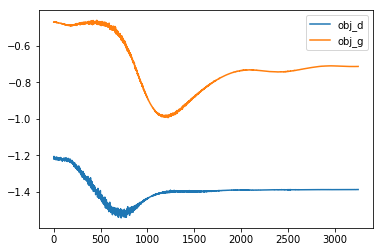

In [13]:
plt.plot(range(len(histd)),histd, label='obj_d')
plt.plot(range(len(histg)), histg, label='obj_g')
plt.legend()

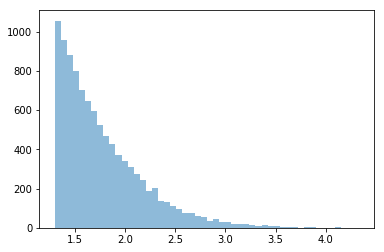

In [14]:
# p_data
xs = gen_conditional_samples(10000, gamma_0, sample_func)
n, bins, patches = plt.hist(xs, 50, alpha=0.5)

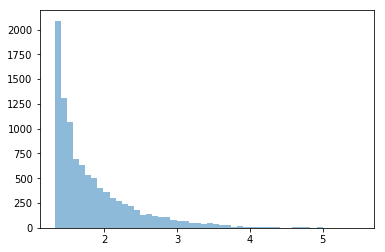

In [15]:
# p_generative
zs = get_noise(10000, n_noise)
gs=np.zeros((10000,1)) # generator function
for i in range(10000//batch_size):
    z=np.reshape(zs[batch_size*i:batch_size*(i+1), 0],(batch_size,1))
    gs[batch_size*i:batch_size*(i+1)]=sess.run(G,{Z: z})
n, bins, patches = plt.hist(gs, 50, alpha=0.5)

In [16]:
gs[1:10]

array([[2.12347579],
       [2.49195886],
       [1.80690682],
       [2.20352125],
       [1.73556185],
       [1.41187596],
       [1.66310322],
       [2.61839104],
       [1.56261003]])

In [17]:
# one of the problem of GAN, easily to be more concentrated at "high mode"
# techniques such as minibatch discrimination might help

In [18]:
gamma_0

1.2971086312023465

In [19]:
gamma_i = compute_gammak(gs[:,0], 0.1)

In [20]:
def gan_sampler(n, sess):
    if n < batch_size:
        z = get_noise(batch_size, 1)
        gs = sess.run(G, {Z:z})
        return gs[:n][:,0]
    else:
        gs = np.zeros((n,1))
        div = n // batch_size
        rem = n % batch_size
        for i in range(div):
            z = get_noise(batch_size, 1)
            gs[batch_size*i:batch_size*(i+1)] = sess.run(G, {Z:z})
        z = get_noise(rem, 1)
        gs[div*batch_size:] = sess.run(G, {Z:z})
        return gs[:,0]

In [21]:
gan_sampler_func = partial(gan_sampler, sess=sess)

In [22]:
X_i = gen_conditional_samples(500, gamma_i, gan_sampler_func)

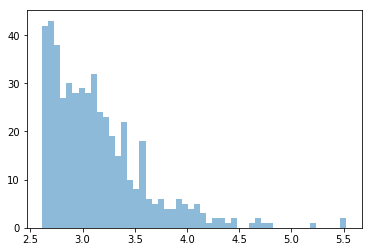

In [23]:
n, bins, patches = plt.hist(X_i, 50, alpha=0.5)

In [24]:
### TODO: importance sampling GAN

In [25]:
# currently we focus on one dimension normal random variable, g(X) = X
# barrier func should be e^{-(x-y)^2}/2h-c/2(log(x-gamma)-log(y-gamma))^2
def compute_sp(dist_type):
    if dist_type == 'normal':
        def normal_sp(x, mu, sigma):
            return -(x-mu)/(2.0*sigma**2)
        return normal_sp

In [26]:
normal_sp = compute_sp('normal')

In [27]:
std_normal_sp = partial(normal_sp, mu=0.0, sigma=1.0)
std_normal_sp(1.0)

-0.5

In [28]:
def compute_kernel_info(kernel_type):
    if kernel_type == 'normal_barrier':
        def normal_barrier(x, y, h, c, gamma):   #TODO: g(x) might be needed in the future, SymPy might be useful to compute symbolic derivative
            kernel_info = {}
            kernel_info['kernel'] = exp(-(x-y)**2/(2.0*h)-(c*(log(x-gamma)-log(y-gamma))**2)/2.0)
            kernel_info['grad_x'] = kernel_info['kernel'] * (-(x-y)/h-c*(log(x-gamma)-log(y-gamma))/(x-gamma))
            kernel_info['grad_y'] = kernel_info['kernel'] * ((x-y)/h+c*(log(x-gamma)-log(y-gamma))/(y-gamma))
            kernel_info['hessian'] = kernel_info['grad_y']*(-(x-y)/h-c*(log(x-gamma)-log(y-gamma))/(x-gamma)) +\
            kernel_info['kernel']*(1/h+c/((x-gamma)*(y-gamma)))
            return kernel_info
        return normal_barrier

In [29]:
normal_barrier = compute_kernel_info('normal_barrier')
normal_barrier_param = partial(normal_barrier, h=1.0, c=1.0, gamma=gamma_i)

In [30]:
normal_barrier_param(11.0, 15.0)

{'kernel': 0.0003109178876194978,
 'grad_x': 0.0012581166503586251,
 'grad_y': -0.001253453417780083,
 'hessian': -0.00475814004928891}

In [31]:
# compute kernel p
def compute_kernel_p(x, y, sp, kernel_info):
    kernel_vals = kernel_info(x,y)
    kernel = kernel_vals['kernel']
    grad_x = kernel_vals['grad_x']
    grad_y = kernel_vals['grad_y']
    hessian_kernel = kernel_vals['hessian']
    return sp(x)*kernel*sp(y) + sp(x)*grad_y + sp(y)*grad_x + hessian_kernel

In [32]:
p_kernel = partial(compute_kernel_p, sp=std_normal_sp, kernel_info=normal_barrier_param)

In [33]:
p_kernel(11.0, 12.0)

19.57114236122378

In [34]:
# compute blackbox importance weights

In [35]:
len(X_i)

500

In [36]:
# generate Kp matrix, noticing it could be very slow to generate high dimension matrix
n = len(X_i)
Kp = matrix(0.0, (n,n))
for i in range(n):
    for j in range(n):
        if i > j:
            Kp[i, j] = Kp[j, i]
        else:
            Kp[i, j] = p_kernel(X_i[i], X_i[j])

In [37]:
Kp

<500x500 matrix, tc='d'>

In [38]:
p = matrix(0.0, (n,1))
G = matrix(0.0, (n,n))
G[::n+1] = -1.0
h = matrix(0.0, (n,1))
A = matrix(1.0, (1,n))
b = matrix(1.0)

wi = qp(Kp, p, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  3.5687e-01 -6.7613e-01  5e+02  2e+01  2e+01
 1:  3.5962e-01 -6.6728e-01  1e+01  4e-01  5e-01
 2:  3.6997e-01 -4.8152e-01  2e+00  4e-02  4e-02
 3:  3.6944e-01  6.7489e-02  3e-01  5e-03  5e-03
 4:  3.6345e-01  2.8066e-01  8e-02  2e-05  2e-05
 5:  3.6257e-01  3.4633e-01  2e-02  4e-06  4e-06
 6:  3.6211e-01  3.5694e-01  5e-03  4e-07  4e-07
 7:  3.6191e-01  3.6079e-01  1e-03  8e-08  8e-08
 8:  3.6186e-01  3.6108e-01  8e-04  5e-08  5e-08
 9:  3.6182e-01  3.6136e-01  5e-04  2e-08  2e-08
10:  3.6179e-01  3.6163e-01  2e-04  7e-09  7e-09
11:  3.6178e-01  3.6164e-01  1e-04  5e-09  5e-09
12:  3.6176e-01  3.6174e-01  3e-05  5e-10  6e-10
13:  3.6176e-01  3.6174e-01  2e-05  3e-10  3e-10
14:  3.6175e-01  3.6174e-01  5e-06  6e-11  6e-11
15:  3.6175e-01  3.6174e-01  2e-06  6e-12  6e-12
16:  3.6174e-01  3.6174e-01  5e-07  1e-12  1e-12
17:  3.6174e-01  3.6174e-01  2e-07  2e-13  3e-13
Optimal solution found.


In [39]:
wi_val = np.array(wi['x'])

(500, 1)